In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load CSV
data = pd.read_csv(r'J:/CancerInst/ImmunoTherapy/Lab_Current/Guillaume Mestrallet/Experiments/MLmetastasis/msk_met_2021/dataMLnogenetic.csv')

# Assuming columns "time" (event/censoring time) and "event" (1 if event occurred, 0 if censored) are present
X = data.drop(columns=["TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING", "MET_STATUS"])  # features
y = Surv.from_dataframe("MET_STATUS", "TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING", data)  # Surv object

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create Leave-One-Out cross-validation procedure
#cv = LeaveOneOut()

# RandomForestSurvival model
rf_survival = RandomSurvivalForest(random_state=42)

# Hyperparameter optimization using GridSearchCV
param_grid = {
    "n_estimators": [10, 100, 250, 500, 1000],
    "max_depth": [None, 10, 15, 25, 50],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 5],
}

grid_search = GridSearchCV(rf_survival, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_
best_model

# Model Evaluation
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Concordance Index (C-index)
c_index_train = concordance_index_censored(y_train['MET_STATUS'], y_train['TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING'], y_pred_train)
c_index_test = concordance_index_censored(y_test['MET_STATUS'], y_test['TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING'], y_pred_test)

print(f"Training C-Index: {c_index_train[0]:.4f}")
print(f"Testing C-Index: {c_index_test[0]:.4f}")

# Combine predictions and ground truth from train and test sets
X_combined = pd.concat([X_train, X_test])
y_combined = np.concatenate([y_train, y_test])
y_pred_combined = np.concatenate([y_pred_train, y_pred_test])

# Calculate the global C-index
c_index_global = concordance_index_censored(y_combined['MET_STATUS'], y_combined['TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING'], y_pred_combined)

print(f"Global C-Index: {c_index_global[0]:.4f}")

Training C-Index: 0.6760
Testing C-Index: 0.6853
Global C-Index: 0.6782


In [2]:
best_model

RandomSurvivalForest(min_samples_leaf=1, min_samples_split=2, n_estimators=10,
                     random_state=42)

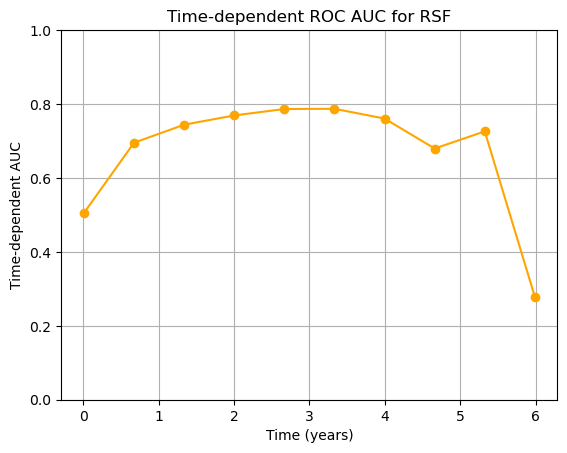

In [3]:
from sksurv.metrics import cumulative_dynamic_auc
import numpy as np

min_time = y_test["TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING"].min()
max_time = y_test["TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING"].max()

# Slightly shrink max time to stay strictly within interval
safe_max_time = max_time * 0.9999

# Generate safe time points
eval_times = np.linspace(min_time, safe_max_time, 10)

# Predict survival functions
pred_surv = best_model.predict_survival_function(X_test)

# Evaluate survival probabilities at the eval_times
pred_surv_matrix = np.asarray([[fn(t) for t in eval_times] for fn in pred_surv])
risk_scores = 1 - pred_surv_matrix

# Compute cumulative/dynamic AUC
cph_auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_scores, eval_times)

#plot
plt.plot(eval_times, cph_auc, marker='o', color='orange', label="data test")
plt.xlabel("Time (years)")
plt.ylabel("Time-dependent AUC")
plt.title("Time-dependent ROC AUC for RSF")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

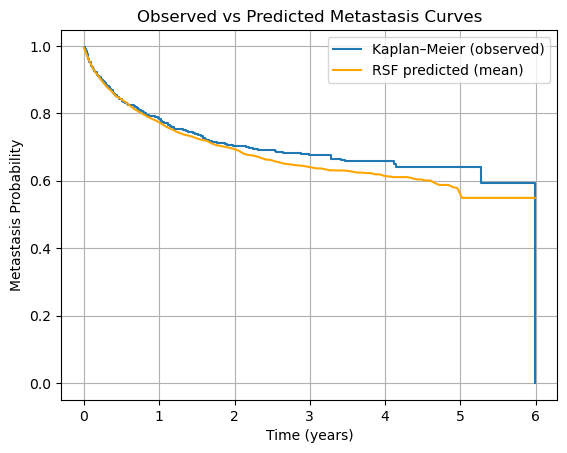

In [4]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

# Get event indicator and durations from test set
event = y_test["MET_STATUS"]
time = y_test["TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING"]

# Compute KM estimate
km_time, km_survival = kaplan_meier_estimator(event, time)

# Predict survival functions for all test samples
pred_surv = best_model.predict_survival_function(X_test)

# Interpolate all survival functions to a common time grid
# Choose a common grid based on the KM time or a linspace
common_time_grid = np.linspace(0, time.max(), 100)

# Interpolate predicted survival values at these times
interp_surv = np.asarray([[fn(t) for t in common_time_grid] for fn in pred_surv])

# Compute mean predicted survival across all test samples
mean_pred_surv = interp_surv.mean(axis=0)

#plot
plt.step(km_time, km_survival, where="post", label="Kaplan–Meier (observed)")
plt.plot(common_time_grid, mean_pred_surv, label="RSF predicted (mean)", color="orange")
plt.xlabel("Time (years)")
plt.ylabel("Metastasis Probability")
plt.title("Observed vs Predicted Metastasis Curves")
plt.grid(True)
plt.legend()
plt.show()